In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
# cPickle和pickle的功能一样，但速度更快，python3已经将cPickle的实现合并到代码中了，所以这里是为了兼容python2
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [7]:
from urllib.request import urlretrieve
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/Users/naijialiu/myML-ud730/data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /Users/naijialiu/myML-ud730/data/notMNIST_large.tar.gz
Found and verified /Users/naijialiu/myML-ud730/data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [8]:
import numpy as np
import tarfile

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/Users/naijialiu/myML-ud730/data/notMNIST_large already present - Skipping extraction of /Users/naijialiu/myML-ud730/data/notMNIST_large.tar.gz.
['/Users/naijialiu/myML-ud730/data/notMNIST_large/A', '/Users/naijialiu/myML-ud730/data/notMNIST_large/B', '/Users/naijialiu/myML-ud730/data/notMNIST_large/C', '/Users/naijialiu/myML-ud730/data/notMNIST_large/D', '/Users/naijialiu/myML-ud730/data/notMNIST_large/E', '/Users/naijialiu/myML-ud730/data/notMNIST_large/F', '/Users/naijialiu/myML-ud730/data/notMNIST_large/G', '/Users/naijialiu/myML-ud730/data/notMNIST_large/H', '/Users/naijialiu/myML-ud730/data/notMNIST_large/I', '/Users/naijialiu/myML-ud730/data/notMNIST_large/J']
/Users/naijialiu/myML-ud730/data/notMNIST_small already present - Skipping extraction of /Users/naijialiu/myML-ud730/data/notMNIST_small.tar.gz.
['/Users/naijialiu/myML-ud730/data/notMNIST_small/A', '/Users/naijialiu/myML-ud730/data/notMNIST_small/B', '/Users/naijialiu/myML-ud730/data/notMNIST_small/C', '/Users/naijialiu/m

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [9]:
from IPython.display import display, Image

def random_files(folder, letter, n):
    folder = data_root + os.path.sep + 'notMNIST_' + folder + os.path.sep + letter + os.path.sep
    for file in os.listdir(folder)[0:n]:
        yield folder + file

for letter in ['A', 'B', 'C']:
    for file in random_files('small', letter, 2):
        print(file)
        display(Image(file))
    for file in random_files('large', letter, 2):
        print(file)
        display(Image(file))


/Users/naijialiu/myML-ud730/data/notMNIST_small/A/MDEtMDEtMDAudHRm.png


/Users/naijialiu/myML-ud730/data/notMNIST_small/A/MDRiXzA4LnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/A/a2F6b28udHRm.png


/Users/naijialiu/myML-ud730/data/notMNIST_small/B/MDEtMDEtMDAudHRm.png


/Users/naijialiu/myML-ud730/data/notMNIST_small/B/MDRiXzA4LnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/B/a29ydW5pc2hpLnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/B/a2F6b28udHRm.png


/Users/naijialiu/myML-ud730/data/notMNIST_small/C/MDEtMDEtMDAudHRm.png


/Users/naijialiu/myML-ud730/data/notMNIST_small/C/MDRiXzA4LnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/C/a29ydW5pc2hpLnR0Zg==.png


/Users/naijialiu/myML-ud730/data/notMNIST_large/C/a2F6b28udHRm.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [10]:
from scipy import ndimage

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), # shape = （文件夹中文件数量， 28， 28）
                         dtype=np.float32) # 浮点数的数值
  print(folder)
  num_images = 0
  for image in image_files:# 遍历某个字母文件夹中的所有文件
    image_file = os.path.join(folder, image)
    try:
        # 用ndimage.imrea读取文件
        # 直接读取文件，不对文件进行任何转换，本身imread方法可以对文件进行灰度等处理：
        # https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.ndimage.imread.html#scipy.ndimage.imread
        # 但这里的原始文件就是28*28像素大小的灰度图，无alpha通道，所以直接读取就可以了，每张图是一个28*28的ndarray
        # 然后进行正则化处理（将每个像素值转换为float，再将值-128/256），存放到image_data变量中，每个元素值介于-0.5到0.5
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    # 有些文件可能有存坏，不是28*28的尺寸，或者干脆无法打开，丢弃掉这些文件
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
    # 然后将这个图片的数据添加到dataset中：根据num_images在dataset这个三维的矩阵中选择一个“1*28*28立体矩阵”，
    # 虽然第一维度只有一个元素，但它仍然是一个三维矩阵，实际用np试了一下，下面的结果都是（28， 28）
    # dataset[num_images].shape，dataset[num_images, :].shape，dataset[num_images, :, :].shape
    # 所以感觉这里用然后用两个冒号，将这个三维矩阵”降维“到二维，是没有必要的，直接用dataset[num_images]应该就可以了
      dataset[num_images] = image_data # 这时改写后的代码，原来的代码是dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    # 只获取可解析图片对应的部分矩阵，矩阵初始为文件数量， 28， 28的大小，但因为有些文件无法读取，实际的有效矩阵比初始化的要小一些
  dataset = dataset[0:num_images] # 同样的原因，这里也可以直接写为这样，原来的代码是dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape) # shape=（可解析的文件数量，28，28）
  print('Mean:', np.mean(dataset)) # mean函数没有指定axis参数，那么将dataset拍平为一维数组，然后计算算术平均值，应该是接近0的一个数
    # std同样没有指定axis参数，那么将dataset拍平为一维数组，然后计算标准差，应该是接近0.5，因为像素值可能的取值范围是-0.5～0.5
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class) # shape=（读取的文件数量，28，28）
      try:
        # 把对象序列化到文件中，HIGHEST_PROTOCOL可以让生成的文件很小，比默认的设置小很多很多
        # http://deeplearning.net/software/theano/tutorial/loading_and_saving.html
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

# 对notMNIST_large文件中的每个字母子文件夹找至少45000个图片作为训练集
# 每个字母生成一个.pickle文件
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800) # 对notMNIST_small文件中每个字母至少找1800个图片作为测试集

/Users/naijialiu/myML-ud730/data/notMNIST_large/A.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/B.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/C.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/D.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/E.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/F.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/G.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/H.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/I.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_large/J.pickle already present - Skipping pickling.
/Users/naijialiu/myML-ud730/data/notMNIST_small/A.pickle alr

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

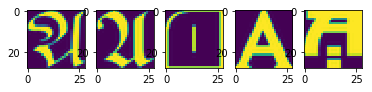

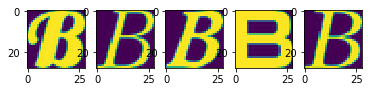

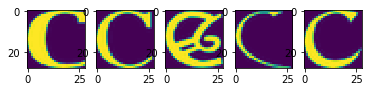

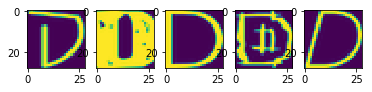

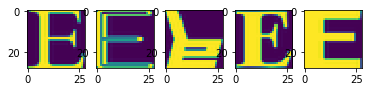

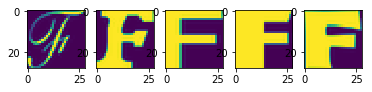

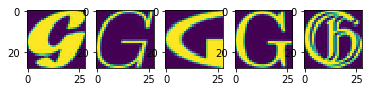

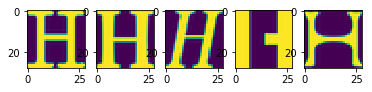

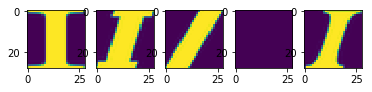

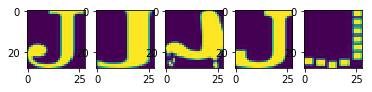

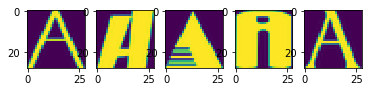

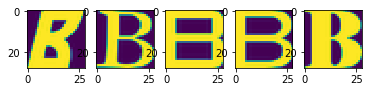

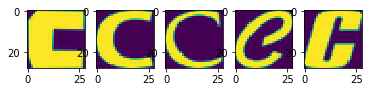

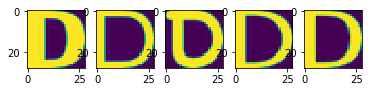

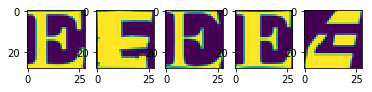

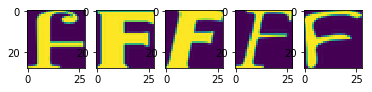

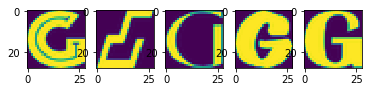

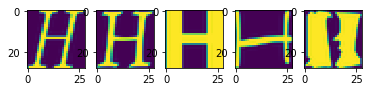

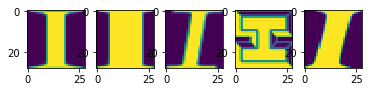

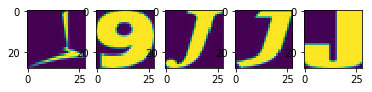

In [11]:
#print(train_datasets)
import random

def get_label_from_file_path(file_path):
    return os.path.basename(file_path).split('.')[0]

def read_file(file_path):
  dataset = pickle.load(open(file_path, "rb"))
  return dataset # 文件中实际的数据集 shape=(文件数量,28,28)

def random_choose(dataset, num):
    num_of_data = dataset.shape[0] # 训练集中包含的数据数量=图片数量
    indexes = random.sample(range(num_of_data), min(num, num_of_data)) # 随机选择num个图片的索引值并放到一个切片中
    return dataset[indexes] # 用这个包含索引值的切片选择一个子数据集

def render_img(data):
    # data中的数据应该是经过正则化处理的，应该*256 + 128才能还原出原来的图片，但不知道为什么下面的这个转换并没有作用
    #img_data = data * pixel_depth + pixel_depth / 2.0
    # 直接输出data就能看到图片，但颜色不对，紫色和黄色似乎是plt默认的色板，所以之后用了plt.gray()方法对图片进行灰度处理
    plt.imshow(data)

def preview_files(files):
    for file in files:
        label = get_label_from_file_path(file)

        dataset = read_file(file)
        num_to_show = 5
        sub_dataset = random_choose(dataset, num_to_show)
        
        plt.figure(file)#开始一个新的figure，只要值不同就认为是一个新的figure
        for idx, data in enumerate(sub_dataset): # 如果想访问idx，必须用enumerate包装对象
            plt.subplot(1, num_to_show, idx + 1)#一行、num_to_show列，正在画第idx+1个图形
            render_img(data)
        plt.plot()

preview_files(test_datasets)
preview_files(train_datasets)




---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [12]:
import statistics

def output_classes_numbers_summary(files):
    classes_numbers = {}
    for file in files:
        klass = os.path.basename(file).split('.')[0]
        dataset = pickle.load(open(file, "rb"))
        classes_numbers[klass] = dataset.shape[0]
    classes_numbers
    print(classes_numbers)
    numbers = classes_numbers.values()
    print("std: %f, mean: %f" % (statistics.pstdev(numbers), statistics.mean(numbers)))#每种分类数量的方差／平均值

print('test datasets')
output_classes_numbers_summary(test_datasets)
print('train datasets')
output_classes_numbers_summary(train_datasets)

test datasets
{'A': 1872, 'B': 1873, 'C': 1873, 'D': 1873, 'E': 1873, 'F': 1872, 'G': 1872, 'H': 1872, 'I': 1872, 'J': 1872}
std: 0.489898, mean: 1872.400000
train datasets
{'A': 52909, 'B': 52911, 'C': 52912, 'D': 52911, 'E': 52912, 'F': 52912, 'G': 52912, 'H': 52912, 'I': 52912, 'J': 52911}
std: 0.916515, mean: 52911.400000


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [13]:
def make_arrays(nb_rows, img_size):
    # 返回一个(nb_rows, img_size, img_size)的数据集和[nb_rows]标签数组
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

# 这段代码的作用很简单，每个输入的文件是一个分类，在每个分类文件中随机选择train_size个数据作为训练集和标签、valid_size个数据作为验证集和标签
def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files) # 10
  valid_dataset, valid_labels = make_arrays(valid_size, image_size) # 验证集的数据量
  train_dataset, train_labels = make_arrays(train_size, image_size) # 训练集的数据量
  vsize_per_class = valid_size // num_classes # “//”是整除符号，得到每个字母的验证集数据量
  tsize_per_class = train_size // num_classes # 每个字母的训练集数据量
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class # 训练集 + 验证集 的数据量
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set) #就地shuffle、只shuffle第一维
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :] # 从整个字母数据集中取[0, vsize_per_class]切片作为验证集
          valid_dataset[start_v:end_v, :, :] = valid_letter # 将对当前字母选择的验证集数据追加到整个验证集中
          valid_labels[start_v:end_v] = label# label是索引值0-9，而不是字母
          start_v += vsize_per_class
          end_v += vsize_per_class
        
        # 用当前字母数据集中剩下的数据“填满”训练集
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size) # 在测试集数据上只返回单个数据集作为测试数据

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def randomize(dataset, labels):
    # permutation的作用：产生一个0到指定的参数值的序列，然后shuffle返回，常常用来从一个数据集中随机返回一些数据
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:] # 返回全部数据集，只不过是第一维的数据是打乱顺序的
  shuffled_labels = labels[permutation] # 按照同样的方式打乱标签集，因为使用了同一个随机序列，所以标签和数据集还是对应的
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

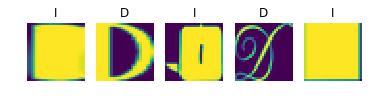

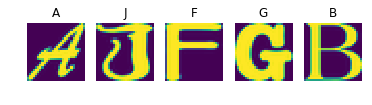

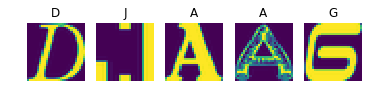

In [15]:
# 随机在数据集中找几个图片显示出来
def show_images_in_dataset(dataset, labels, num_img):
    total_num_image = dataset.shape[0]
    num_img = min(total_num_image, num_img)
    permutation = np.random.permutation(total_num_image)[:num_img]
    sub_dataset = dataset[permutation]
    sub_labels = labels[permutation]
    for idx, data in enumerate(sub_dataset):
        #plt.figure(file)#开始一个新的figure，只要值不同就认为是一个新的figure
        plt.subplot(1, num_img, idx + 1)#一行、num_to_show列，正在画第idx+1个图形
        plt.imshow(data)
        plt.title(chr(ord('A') + sub_labels[idx])) # ord生成字符的ascii码，chr从ascii码转换为字符
        plt.axis('off')
    plt.show()
    
show_images_in_dataset(train_dataset, train_labels, 5)
show_images_in_dataset(test_dataset, test_labels, 5)
show_images_in_dataset(valid_dataset, valid_labels, 5)

Finally, let's save the data for later reuse:

In [16]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [322]:
# 先计算一下每个数据集中的白图，因为我发现了很多
def num_of_blank_images(dataset, labels):
    for index, img in enumerate(dataset):
        if np.all(dataset[index] == 0.5):
            yield labels[index]

def check_empty_image(dataset, labels):            
    empty_images = [0 for i in range(10)]
    empty_img_labels = num_of_blank_images(dataset, labels)
    for l in empty_img_labels:
        empty_images[l] += 1

    for l, n in enumerate(empty_images):
        if n > 0:
            print('{0}: {1}'.format(l, n))

print('train set')
check_empty_image(train_dataset, train_labels)

print('valid set')
check_empty_image(valid_dataset, valid_labels)

print('test set')
check_empty_image(test_dataset, test_labels)

train set
0: 2
1: 5
2: 3
3: 1
4: 4
5: 2
6: 2
7: 4
8: 2147
9: 6
valid set
2: 1
6: 1
8: 111
test set
8: 131


test dataset signature: (10000, 784)
valid dataset signature: (10000, 784)
train dataset signature: (200000, 784)
0.75% 1.49% 2.77% 3.4% 4.59% 6.31% 6.95% 9.59% 11.51% 12.23% 14.8% 15.45% 16.18% 17.63% 17.79% 19.63% 20.69% 21.02% 22.45% 22.51% 23.21% 23.22% 24.6% 28.63% 29.22% 33.84% 34.53% 35.88% 40.09% 40.55% 40.81% 40.84% 41.55% 45.02% 45.82% 46.73% 48.04% 49.37% 50.84% 51.81% 52.15% 54.72% 54.89% 56.25% 59.33% 60.76% 63.59% 65.11% 67.08% 67.56% 67.69% 69.19% 70.04% 70.12% 70.31% 70.35% 70.37% 70.42% 70.43% 70.93% 71.05% 71.12% 71.34% 71.36% 71.6% 71.63% 71.74% 71.76% 71.84% 71.85% 71.94% 71.98% 72.02% 72.08% 72.17% 72.25% 72.36% 72.67% 72.74% 73.05% 73.06% 73.15% 73.23% 73.4% 73.58% 73.65% 73.66% 73.8% 74.07% 74.1% 74.12% 74.24% 74.55% 74.85% 75.24% 75.36% 75.63% 75.81% 75.88% 75.97% 76.03% 76.04% 76.07% 76.2% 76.27% 76.39% 76.41% 76.48% 76.51% 76.62% 76.68% 76.7% 76.78% 76.84% 76.92% 76.94% 76.95% 77.08% 77.17% 77.29% 77.5% 77.56% 77.57% 77.72% 78.01% 78.08% 78.19% 78.2% 78.42% 78

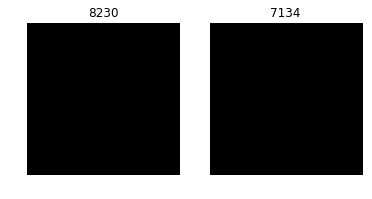

82.33% 82.34% 82.35% 82.38% 82.43% 82.6% 82.66% 82.74% 82.91% 82.93% 82.98% 82.99% 83.01% 83.03% 83.08% 83.13% 83.18% 83.21% 83.29% 83.32% 83.54% 83.57% 83.58% 83.64% 83.7% 83.77% 83.79% 83.8% 83.82% 83.83% 83.89% 83.92% 83.94% 84.0% 84.01% 84.02% 84.06% 84.11% 84.14% 84.18% 84.25% 84.35% 84.36% 84.38% 84.4% 84.42% 84.47% 84.51% 84.52% 84.58% 84.63% 84.74% 84.75% 84.77% 84.85% 84.94% 85.04% 85.08% 85.12% 85.19% 85.2% 85.22% 85.23% 85.28% 85.42% 85.5% 85.53% 85.65% 85.74% 85.79% 85.84% 85.85% 85.86% 85.92% 86.03% 86.08% 86.14% 86.19% 86.2% 86.22% 86.31% 86.32% 86.38% 86.41% 86.42% 86.48% 86.61% 86.73% 86.79% 86.8% 86.81% 86.86% 86.94% 86.98% 87.03% 87.04% 87.08% 87.12% 87.19% 87.2% 87.21% 87.27% 87.29% 87.32% 87.4% 87.43% 87.46% 87.56% 87.59% 87.62% 87.65% 87.66% 87.75% 88.16% 88.22% 88.28% 88.35% 88.45% 88.47% 88.52% 88.54% 88.71% 88.73% 88.75% 88.77% 88.8% 88.81% 88.84% 88.93% 88.95% 89.01% 89.03% 89.12% 89.41% 89.43% 89.44% 89.52% 89.73% 89.85% 89.94% 89.96% 90.91% 91.35% 92.93% 93.4

In [303]:
# 用距离衡量两个图片的相似程度？threholde 可以体现出两张图片不同的像素点个数，1表示两个图片完全相同
def compare_signatures(sig_set1, sig_set2, threshold = 1):
    for idx1, sig1 in enumerate(sig_set1):
        # 计算当前正在遍历的图片签名（sig1）与sig_set2中所有签名的距离
        diff = sig_set2 ^ sig1 # shape = (sig_set2.shape[0], 784) # 第二维表示每个签名位（像素）是否有差异
        distances = np.sum(diff, axis=1) # shape = (sig_set2.shape[0],) # 汇总有差异的签名位（像素）个数
        # 找出与sig_set2中与sig1足够接近的图片索引值
        # 如果签名位（像素点）的数量差异<阈值，说明图片接近，threhold = 1表示图片完全一致，输出这样图片的下标
        for idx2 in np.argwhere(distances < threshold).flatten():
            yield (idx1, idx2)
            break # 只输出一张匹配图即可，因为有很多白图，交叉匹配的结果数量太大

def cacl_hamming_signature(img_data):
    m = np.mean(img_data)
    return np.where(img_data - m >= 0, True, False).ravel() # ravel()转1维

def cacl_hamming_signatures(dataset):
    n = dataset.shape[0]
    # signatures是一个二维矩阵，每个图片的签名是每个像素相比平均值的bool值的一维数组
    signateres = np.empty([n, dataset.shape[1] * dataset.shape[2]], dtype = bool)
    for idx, data in enumerate(dataset):
        signateres[idx] = cacl_hamming_signature(data)
    return signateres
    
a = test_dataset
b = valid_dataset
c = train_dataset

a_signatures = cacl_hamming_signatures(a)
print('test dataset signature: {0}'.format(a_signatures.shape))

b_signatures = cacl_hamming_signatures(b)
print('valid dataset signature: {0}'.format(b_signatures.shape))

c_signatures = cacl_hamming_signatures(c)
print('train dataset signature: {0}'.format(c_signatures.shape))

In [ ]:
num = 0
for (idx1, idx2) in compare_signatures(a_signatures, b_signatures):
    num += 1
    if num % 200 == 0:
        plt.subplot(121)
        plt.title(str(idx1))
        plt.imshow(a[idx1])
        plt.axis('off')
    
        plt.subplot(122)
        plt.title(str(idx2))
        plt.imshow(b[idx2])
        plt.axis('off')

        plt.show()
    else:
        print('{0}% '.format(idx1 * 100.0 / a_signatures.shape[0]), end='')
print('done: {0}'.format(num))
# test和valid重合图片357个，比率大约为3.5%
# test和train重合图片1741个，比率大约为0.87%
# valid和train重合图片1468个，比率大约为0.73%

0.01% 0.04% 0.18% 0.19% 0.29% 0.31% 0.32% 0.37% 0.54% 0.59% 0.61% 0.82% 1.09% 1.19% 1.24% 1.4% 1.42% 1.57% 1.62% 1.63% 1.65% 1.68% 1.71% 1.75% 1.82% 1.91% 1.97% 2.03% 2.13% 2.24% 2.28% 2.34% 2.38% 2.53% 2.55% 2.69% 2.74% 2.76% 2.77% 2.79% 2.83% 2.9% 3.12% 3.21% 3.25% 3.43% 3.52% 3.61% 3.81% 3.85% 3.91% 3.97% 3.98% 4.04% 4.16% 4.22% 4.23% 4.27% 4.3% 4.33% 4.37% 4.46% 4.63% 4.68% 4.73% 4.82% 4.85% 5.01% 5.03% 5.13% 5.3% 5.31% 5.51% 5.64% 5.67% 5.69% 5.79% 5.84% 5.93% 5.97% 5.98% 6.05% 6.06% 6.12% 6.14% 6.15% 6.17% 6.24% 6.25% 6.3% 6.32% 6.39% 6.48% 6.5% 6.55% 6.62% 6.68% 7.0% 7.07% 7.09% 7.23% 7.24% 7.28% 7.43% 7.45% 7.48% 7.71% 7.73% 7.8% 7.82% 7.85% 7.87% 7.88% 7.9% 7.92% 7.94% 7.97% 8.12% 8.16% 8.18% 8.43% 8.54% 8.64% 8.83% 8.85% 8.9% 8.91% 9.15% 9.19% 9.25% 9.44% 9.55% 9.57% 9.59% 9.64% 9.75% 9.78% 9.79% 9.8% 9.84% 9.93% 9.95% 9.97% 9.98% 10.08% 10.17% 10.3% 10.35% 10.36% 10.69% 10.83% 10.91% 10.95% 10.98% 11.01% 11.07% 11.15% 11.29% 11.32% 11.51% 11.69% 11.76% 11.82% 11.86% 11.93% 1

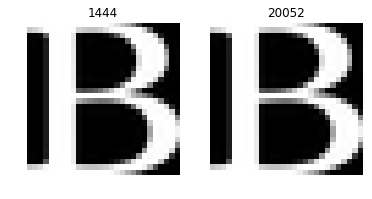

14.45% 14.55% 14.56% 14.6% 14.66% 14.69% 14.7% 14.72% 14.75% 14.84% 14.97% 15.01% 15.14% 15.34% 15.37% 15.57% 15.6% 15.61% 15.77% 15.82% 15.87% 15.91% 16.09% 16.36% 16.37% 16.4% 16.46% 16.51% 16.72% 16.77% 16.78% 16.96% 17.1% 17.12% 17.28% 17.48% 17.49% 17.53% 17.55% 17.76% 17.87% 17.9% 17.92% 18.11% 18.25% 18.32% 18.33% 18.47% 18.8% 18.83% 18.84% 18.92% 18.93% 18.94% 18.97% 18.98% 19.04% 19.17% 19.24% 19.27% 19.28% 19.31% 19.44% 19.45% 19.59% 19.61% 19.64% 19.66% 19.7% 19.75% 19.77% 19.78% 19.91% 19.94% 19.98% 20.0% 20.04% 20.14% 20.2% 20.3% 20.33% 20.51% 20.61% 20.8% 20.93% 20.95% 21.02% 21.09% 21.12% 21.18% 21.21% 21.22% 21.28% 21.34% 21.49% 21.54% 21.67% 21.71% 21.72% 22.1% 22.12% 22.15% 22.3% 22.52% 22.64% 22.82% 22.86% 22.88% 22.96% 23.03% 23.08% 23.12% 23.17% 23.18% 23.21% 23.31% 23.37% 23.42% 23.46% 23.56% 23.69% 23.83% 23.84% 24.0% 24.06% 24.08% 24.17% 24.21% 24.35% 24.45% 24.6% 24.64% 24.71% 24.73% 24.78% 24.82% 25.08% 25.1% 25.23% 25.57% 25.71% 25.79% 25.82% 26.07% 26.16% 26

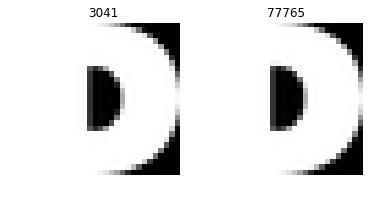

30.48% 30.68% 31.18% 31.26% 31.3% 31.51% 31.56% 31.57% 31.81% 32.03% 32.06% 32.11% 32.15% 32.25% 32.26% 32.37% 32.42% 32.5% 32.67% 32.75% 32.79% 32.98% 33.06% 33.1% 33.32% 33.34% 33.35% 33.53% 33.69% 33.75% 33.78% 33.85% 33.92% 34.08% 34.37% 34.45% 34.5% 34.55% 34.56% 34.6% 34.68% 34.69% 34.94% 35.0% 35.06% 35.08% 35.09% 35.2% 35.29% 35.35% 35.45% 35.57% 35.65% 35.68% 35.74% 35.79% 35.98% 36.01% 36.07% 36.09% 36.1% 36.14% 36.21% 36.27% 36.33% 36.41% 36.47% 36.48% 36.52% 36.54% 36.56% 36.6% 36.64% 36.71% 36.73% 36.98% 37.04% 37.12% 37.13% 37.17% 37.48% 37.5% 37.59% 37.64% 37.68% 37.79% 37.87% 37.98% 38.13% 38.24% 38.43% 38.52% 38.55% 38.56% 38.68% 38.74% 38.87% 38.89% 38.91% 38.92% 38.93% 38.98% 39.05% 39.06% 39.15% 39.22% 39.27% 39.31% 39.33% 39.5% 39.54% 39.67% 39.72% 39.79% 39.81% 39.95% 40.5% 40.59% 40.62% 40.81% 40.91% 40.96% 41.0% 41.02% 41.06% 41.07% 41.09% 41.14% 41.17% 41.32% 41.33% 41.37% 41.39% 41.43% 41.48% 41.54% 41.55% 41.58% 41.62% 41.77% 41.81% 41.83% 41.86% 41.9% 41.94%

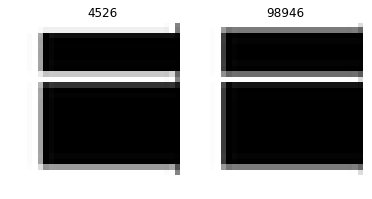

45.27% 45.32% 45.35% 45.38% 45.48% 45.5% 45.52% 45.54% 45.59% 45.68% 45.73% 45.86% 45.87% 45.91% 45.93% 45.94% 45.99% 46.05% 46.14% 46.18% 46.2% 46.23% 46.32% 46.42% 46.43% 46.44% 46.54% 46.68% 46.78% 46.87% 46.91% 46.96% 46.97% 47.15% 47.2% 47.21% 47.3% 47.33% 47.44% 47.61% 47.71% 47.72% 47.84% 47.87% 47.9% 47.92% 47.98% 48.01% 48.1% 48.23% 48.36% 48.39% 48.55% 48.57% 48.63% 48.7% 48.74% 48.77% 48.8% 48.87% 48.92% 48.95% 49.12% 49.15% 49.28% 49.32% 49.35% 49.37% 49.42% 49.74% 49.81% 49.87% 49.9% 49.95% 50.03% 50.04% 50.09% 50.11% 50.34% 50.38% 50.39% 50.54% 50.67% 50.72% 50.73% 50.75% 50.78% 50.81% 50.84% 50.94% 50.98% 51.03% 51.05% 51.1% 51.13% 51.2% 51.22% 51.33% 51.4% 51.43% 51.58% 51.59% 51.65% 51.66% 51.67% 51.81% 51.83% 51.9% 51.91% 52.0% 52.15% 52.27% 52.37% 52.41% 52.55% 52.65% 52.75% 52.8% 52.86% 52.93% 52.97% 53.04% 53.13% 53.2% 53.23% 53.26% 53.29% 53.44% 53.47% 53.5% 53.53% 53.62% 53.67% 53.84% 53.91% 53.93% 54.01% 54.08% 54.1% 54.22% 54.27% 54.29% 54.32% 54.38% 54.42% 54.

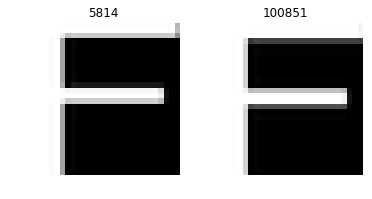

58.25% 58.32% 58.42% 58.49% 58.53% 58.57% 58.62% 58.67% 58.88% 58.97% 59.05% 59.06% 59.12% 59.15% 59.18% 59.22% 59.24% 59.28% 59.35% 59.51% 59.52% 59.55% 59.67% 59.68% 59.69% 59.7% 59.85% 59.87% 59.89% 59.94% 59.99% 60.14% 60.19% 60.31% 60.5% 60.51% 60.76% 60.77% 61.08% 61.36% 61.5% 61.52% 61.61% 61.7% 61.73% 61.75% 61.79% 61.8% 61.87% 61.9% 61.91% 61.99% 62.32% 62.34% 62.4% 62.63% 62.72% 62.74% 62.82% 62.93% 62.98% 63.04% 63.13% 63.2% 63.21% 63.36% 63.39% 63.41% 63.5% 63.57% 63.59% 63.66% 63.68% 63.71% 63.72% 63.76% 63.82% 63.83% 63.92% 64.02% 64.03% 64.07% 64.23% 64.26% 64.32% 64.34% 64.36% 64.41% 64.43% 64.53% 64.58% 64.61% 64.81% 64.88% 65.04% 65.06% 65.11% 65.19% 65.25% 65.63% 65.69% 65.96% 66.11% 66.16% 66.32% 66.47% 66.49% 66.55% 66.58% 66.59% 66.61% 66.63% 66.72% 66.75% 66.84% 66.85% 66.9% 66.97% 67.0% 67.09% 67.31% 67.42% 67.47% 67.52% 67.53% 67.56% 67.69% 67.82% 67.88% 67.92% 68.12% 68.19% 68.24% 68.38% 68.77% 68.92% 69.09% 69.26% 69.49% 69.51% 69.53% 69.6% 69.62% 69.65% 69.9

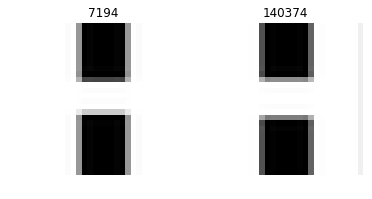

71.98% 72.02% 72.04% 72.08% 72.17% 72.24% 72.25% 72.36% 72.42% 72.43% 72.48% 72.67% 72.74% 72.75% 72.77% 72.78% 72.85% 72.88% 72.92% 72.96% 72.97% 73.04% 73.05% 73.06% 73.09% 73.12% 73.15% 73.16% 73.18% 73.23% 73.32% 73.33% 73.4% 73.41% 73.44% 73.47% 73.51% 73.52% 73.53% 73.55% 73.58% 73.65% 73.66% 73.7% 73.71% 73.73% 73.77% 73.83% 73.86% 73.89% 73.94% 73.95% 73.98% 74.07% 74.1% 74.12% 74.13% 74.2% 74.24% 74.25% 74.32% 74.4% 74.41% 74.44% 74.47% 74.5% 74.55% 74.57% 74.61% 74.63% 74.64% 74.7% 74.81% 74.83% 74.85% 74.86% 74.89% 75.03% 75.06% 75.13% 75.24% 75.25% 75.36% 75.41% 75.42% 75.43% 75.49% 75.52% 75.63% 75.76% 75.78% 75.81% 75.82% 75.88% 75.9% 75.95% 75.96% 75.97% 76.01% 76.02% 76.03% 76.04% 76.07% 76.09% 76.17% 76.19% 76.2% 76.21% 76.22% 76.23% 76.25% 76.27% 76.28% 76.3% 76.35% 76.38% 76.39% 76.41% 76.44% 76.48% 76.51% 76.61% 76.62% 76.65% 76.68% 76.7% 76.75% 76.76% 76.78% 76.82% 76.84% 76.88% 76.92% 76.93% 76.94% 76.95% 76.97% 77.06% 77.08% 77.1% 77.17% 77.22% 77.23% 77.24% 77.2

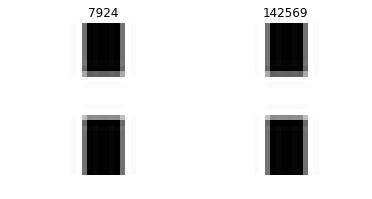

79.26% 79.29% 79.31% 79.34% 79.36% 79.37% 79.38% 79.5% 79.58% 79.6% 79.62% 79.63% 79.66% 79.71% 79.73% 79.74% 79.75% 79.82% 79.91% 79.92% 80.0% 80.03% 80.06% 80.07% 80.08% 80.1% 80.11% 80.12% 80.13% 80.15% 80.18% 80.19% 80.22% 80.24% 80.26% 80.27% 80.29% 80.3% 80.32% 80.4% 80.43% 80.48% 80.52% 80.56% 80.57% 80.6% 80.64% 80.65% 80.67% 80.72% 80.74% 80.75% 80.76% 80.77% 80.8% 80.83% 80.87% 80.91% 80.92% 80.95% 80.97% 81.02% 81.04% 81.07% 81.17% 81.18% 81.19% 81.23% 81.26% 81.28% 81.3% 81.32% 81.34% 81.4% 81.43% 81.45% 81.46% 81.47% 81.48% 81.5% 81.52% 81.55% 81.56% 81.57% 81.58% 81.64% 81.68% 81.69% 81.71% 81.73% 81.74% 81.75% 81.76% 81.78% 81.79% 81.8% 81.82% 81.88% 81.89% 81.9% 81.96% 81.99% 82.01% 82.06% 82.12% 82.13% 82.14% 82.16% 82.17% 82.2% 82.21% 82.22% 82.23% 82.24% 82.25% 82.3% 82.33% 82.34% 82.35% 82.38% 82.39% 82.43% 82.44% 82.47% 82.49% 82.53% 82.59% 82.6% 82.66% 82.67% 82.68% 82.69% 82.74% 82.78% 82.81% 82.85% 82.86% 82.9% 82.91% 82.92% 82.93% 82.96% 82.97% 82.98% 82.99% 83

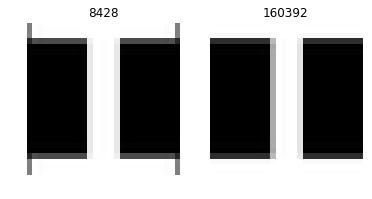

84.29% 84.31% 84.35% 84.36% 84.38% 84.39% 84.4% 84.42% 84.45% 84.47% 84.48% 84.51% 84.52% 84.53% 84.54% 84.58% 84.6% 84.63% 84.71% 84.74% 84.75% 84.77% 84.85% 84.87% 84.88% 84.94% 85.04% 85.08% 85.11% 85.12% 85.13% 85.16% 85.19% 85.2% 85.21% 85.22% 85.28% 85.33% 85.42% 85.47% 85.49% 85.5% 85.53% 85.54% 85.62% 85.64% 85.65% 85.69% 85.7% 85.71% 85.74% 85.78% 85.79% 85.8% 85.84% 85.85% 85.86% 85.89% 85.9% 85.92% 85.93% 85.96% 86.0% 86.03% 86.04% 86.05% 86.08% 86.1% 86.11% 86.14% 86.19% 86.2% 86.22% 86.23% 86.26% 86.31% 86.32% 86.37% 86.38% 86.41% 86.42% 86.44% 86.46% 86.47% 86.48% 86.52% 86.57% 86.59% 86.61% 86.66% 86.71% 86.73% 86.77% 86.79% 86.8% 86.81% 86.83% 86.86% 86.87% 86.88% 86.94% 86.96% 86.98% 87.03% 87.04% 87.05% 87.08% 87.12% 87.15% 87.18% 87.19% 87.2% 87.21% 87.25% 87.27% 87.29% 87.3% 87.32% 87.33% 87.4% 87.43% 87.46% 87.47% 87.53% 87.56% 87.59% 87.6% 87.61% 87.62% 87.63% 87.65% 87.66% 87.7% 87.75% 87.78% 87.84% 87.86% 87.87% 87.93% 87.95% 88.07% 88.11% 88.16% 88.19% 88.2% 88

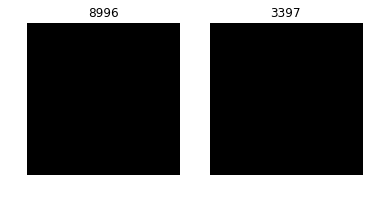

89.97% 89.99% 90.13% 90.14% 90.15% 90.17% 90.22% 90.28% 90.29% 90.34% 90.39% 90.45% 90.48% 90.56% 90.61% 90.69% 90.75% 90.9% 90.93% 90.95% 91.02% 91.13% 91.18% 91.19% 91.25% 91.32% 91.5% 91.52% 91.54% 91.55% 91.69% 91.77% 91.9% 91.94% 92.01% 92.12% 92.27% 92.32% 92.48% 92.49% 92.5% 92.52% 92.54% 92.6% 92.65% 92.67% 92.69% 92.78% 92.82% 92.86% 92.9% 93.01% 93.03% 93.09% 93.28% 93.3% 93.37% 93.61% 93.65% 93.87% 94.03% 94.06% 94.15% 94.16% 94.19% 94.29% 94.34% 94.4% 94.41% 94.48% 94.49% 94.51% 94.54% 94.77% 94.8% 94.81% 94.86% 94.93% 95.0% 95.15% 95.25% 95.3% 95.42% 95.44% 95.57% 95.67% 95.71% 95.81% 96.06% 96.22% 96.24% 96.28% 96.32% 96.34% 96.37% 96.47% 96.65% 96.71% 96.74% 96.84% 96.88% 96.93% 96.99% 97.12% 97.51% 97.62% 97.76% 97.87% 97.92% 98.03% 98.2% 98.22% 98.24% 98.27% 98.34% 98.52% 98.57% 98.58% 98.67% 98.75% 98.76% 98.79% 98.8% 98.81% 98.82% 98.84% 98.98% 98.99% 99.04% 99.25% 99.28% 99.29% 99.45% 99.49% 99.6% 99.61% 99.63% 99.69% 99.91% 99.94% 99.95% done: 1741
0.12% 0.2% 0.32%

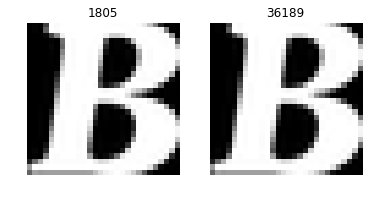

18.14% 18.15% 18.33% 18.37% 18.55% 18.62% 18.77% 18.8% 18.99% 19.19% 19.34% 19.36% 19.38% 19.52% 19.57% 19.7% 19.83% 20.03% 20.19% 20.2% 20.32% 20.46% 20.52% 20.54% 20.74% 20.95% 20.97% 20.98% 21.1% 21.4% 21.5% 21.53% 21.58% 21.64% 21.65% 21.7% 21.71% 21.78% 21.88% 22.02% 22.1% 22.19% 22.22% 22.27% 22.29% 22.42% 22.43% 22.5% 22.69% 22.86% 22.88% 23.11% 23.15% 23.34% 23.49% 23.51% 23.55% 23.67% 23.78% 23.8% 23.87% 23.88% 23.89% 24.01% 24.08% 24.13% 24.3% 24.47% 24.57% 24.6% 24.61% 24.78% 25.12% 25.23% 25.24% 25.37% 25.58% 25.65% 25.67% 25.75% 25.81% 25.88% 25.97% 26.17% 26.3% 26.41% 26.66% 26.9% 26.99% 27.0% 27.01% 27.03% 27.04% 27.05% 27.06% 27.1% 27.31% 27.41% 27.47% 27.48% 27.5% 27.54% 27.56% 27.62% 27.63% 27.89% 28.11% 28.3% 28.72% 28.76% 28.77% 28.82% 28.94% 28.97% 28.99% 29.0% 29.24% 29.31% 29.36% 29.47% 29.51% 29.59% 29.65% 29.69% 29.83% 29.85% 30.02% 30.22% 30.25% 30.39% 30.43% 30.44% 30.47% 30.5% 30.71% 30.79% 30.84% 30.93% 30.97% 31.03% 31.14% 31.19% 31.27% 31.49% 31.63% 31.77

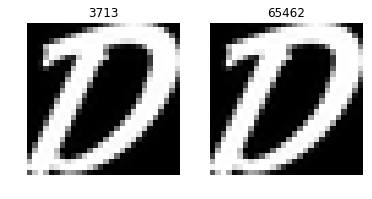

37.14% 37.26% 37.49% 37.51% 37.62% 37.74% 37.79% 37.86% 37.92% 37.95% 38.09% 38.18% 38.41% 38.65% 38.78% 39.05% 39.1% 39.19% 39.23% 39.25% 39.34% 39.37% 39.4% 39.43% 39.51% 39.59% 39.69% 39.7% 39.75% 39.79% 39.81% 39.88% 40.02% 40.05% 40.15% 40.21% 40.25% 40.38% 40.41% 40.45% 40.65% 40.77% 40.9% 41.04% 41.15% 41.26% 41.31% 41.49% 41.58% 41.66% 41.76% 41.78% 41.83% 41.9% 41.98% 41.99% 42.14% 42.25% 42.39% 42.52% 42.56% 42.59% 42.68% 42.98% 43.0% 43.04% 43.07% 43.09% 43.11% 43.13% 43.18% 43.21% 43.37% 43.38% 43.43% 43.46% 43.47% 43.49% 43.54% 43.56% 43.63% 43.84% 44.01% 44.03% 44.07% 44.08% 44.16% 44.39% 44.5% 44.59% 44.66% 44.69% 44.81% 44.87% 44.89% 44.95% 45.06% 45.16% 45.29% 45.32% 45.34% 45.64% 45.67% 45.7% 45.71% 45.81% 45.86% 46.02% 46.05% 46.06% 46.08% 46.15% 46.22% 46.3% 46.31% 46.34% 46.52% 46.55% 46.61% 46.63% 46.64% 46.73% 46.87% 47.06% 47.15% 47.28% 47.33% 47.35% 47.46% 47.56% 47.57% 47.69% 47.79% 47.87% 47.93% 47.99% 48.0% 48.09% 48.16% 48.19% 48.56% 48.86% 48.89% 48.9% 49.

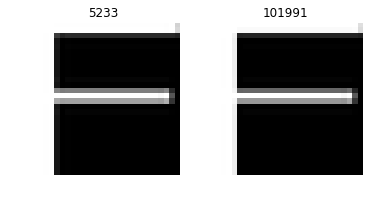

52.54% 52.57% 52.58% 52.6% 52.65% 52.7% 52.71% 52.94% 52.98% 53.04% 53.19% 53.25% 53.26% 53.32% 53.36% 53.37% 53.44% 53.47% 53.63% 53.76% 53.84% 53.95% 53.96% 54.03% 54.05% 54.16% 54.32% 54.44% 54.45% 54.49% 54.71% 54.74% 54.78% 54.84% 54.93% 55.0% 55.1% 55.18% 55.25% 55.28% 55.39% 55.42% 55.45% 55.64% 55.66% 55.7% 55.74% 55.75% 55.78% 55.84% 55.86% 55.87% 55.93% 56.09% 56.15% 56.17% 56.18% 56.2% 56.31% 56.34% 56.45% 56.55% 56.66% 56.69% 56.75% 56.8% 56.97% 57.06% 57.24% 57.25% 57.29% 57.36% 57.37% 57.38% 57.52% 57.64% 57.75% 58.03% 58.1% 58.16% 58.28% 58.36% 58.49% 58.52% 58.75% 58.76% 58.91% 58.92% 58.95% 59.11% 59.32% 59.41% 59.52% 59.65% 59.68% 59.69% 59.7% 59.79% 59.82% 60.1% 60.28% 60.41% 60.5% 60.69% 60.71% 60.75% 60.82% 60.91% 61.05% 61.13% 61.25% 61.3% 61.38% 61.39% 61.48% 61.62% 61.88% 62.0% 62.01% 62.08% 62.17% 62.27% 62.29% 62.32% 62.45% 62.55% 62.57% 62.59% 62.68% 62.76% 62.77% 63.05% 63.12% 63.72% 63.87% 63.99% 64.05% 64.1% 64.19% 64.34% 64.53% 64.73% 64.75% 64.96% 65.29%

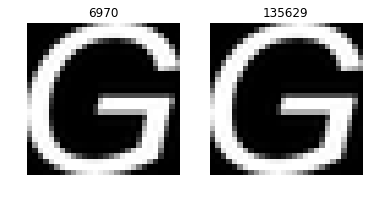

69.83% 69.96% 70.02% 70.03% 70.23% 70.24% 70.34% 70.35% 70.39% 70.46% 70.49% 70.52% 70.58% 70.72% 70.74% 70.76% 70.85% 70.92% 71.04% 71.07% 71.17% 71.18% 71.25% 71.28% 71.29% 71.33% 71.34% 71.41% 71.44% 71.49% 71.5% 71.67% 71.71% 71.8% 71.81% 71.82% 71.83% 71.85% 71.87% 71.89% 71.92% 71.98% 72.0% 72.03% 72.12% 72.13% 72.27% 72.36% 72.38% 72.51% 72.59% 72.65% 72.7% 72.72% 72.77% 72.79% 72.82% 72.85% 72.92% 72.93% 72.96% 73.01% 73.03% 73.04% 73.06% 73.07% 73.08% 73.09% 73.12% 73.19% 73.29% 73.35% 73.37% 73.4% 73.42% 73.44% 73.45% 73.48% 73.52% 73.6% 73.63% 73.67% 73.68% 73.74% 73.81% 73.9% 73.92% 73.99% 74.06% 74.13% 74.17% 74.18% 74.23% 74.24% 74.32% 74.35% 74.41% 74.42% 74.45% 74.48% 74.49% 74.62% 74.69% 74.73% 74.81% 74.85% 74.87% 74.9% 74.91% 74.93% 74.95% 74.99% 75.02% 75.1% 75.12% 75.17% 75.22% 75.27% 75.37% 75.41% 75.54% 75.57% 75.65% 75.66% 75.72% 75.82% 75.83% 75.84% 75.85% 75.88% 75.9% 75.91% 75.92% 75.97% 76.04% 76.12% 76.14% 76.27% 76.31% 76.37% 76.38% 76.41% 76.48% 76.53% 76

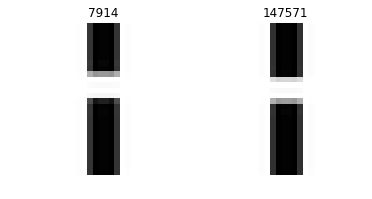

79.17% 79.31% 79.39% 79.46% 79.47% 79.48% 79.49% 79.5% 79.51% 79.53% 79.55% 79.67% 79.7% 79.72% 79.76% 79.77% 79.79% 79.81% 79.85% 79.87% 79.97% 79.99% 80.0% 80.03% 80.1% 80.12% 80.15% 80.2% 80.22% 80.23% 80.33% 80.34% 80.35% 80.38% 80.4% 80.41% 80.42% 80.46% 80.5% 80.59% 80.61% 80.62% 80.64% 80.66% 80.67% 80.69% 80.73% 80.77% 80.81% 80.82% 80.83% 80.85% 80.87% 80.88% 80.92% 80.94% 80.97% 80.98% 81.05% 81.08% 81.15% 81.18% 81.24% 81.25% 81.27% 81.45% 81.51% 81.52% 81.55% 81.58% 81.59% 81.64% 81.65% 81.66% 81.67% 81.69% 81.75% 81.79% 81.8% 81.83% 81.86% 81.91% 81.93% 81.94% 82.02% 82.04% 82.05% 82.12% 82.13% 82.18% 82.22% 82.24% 82.25% 82.35% 82.38% 82.42% 82.5% 82.52% 82.53% 82.59% 82.69% 82.7% 82.72% 82.74% 82.77% 82.8% 82.86% 82.9% 82.94% 83.02% 83.04% 83.05% 83.07% 83.08% 83.09% 83.1% 83.13% 83.21% 83.23% 83.25% 83.28% 83.29% 83.3% 83.35% 83.36% 83.39% 83.43% 83.45% 83.49% 83.5% 83.55% 83.56% 83.58% 83.6% 83.61% 83.65% 83.67% 83.68% 83.69% 83.71% 83.81% 83.82% 83.85% 83.86% 83.94% 8

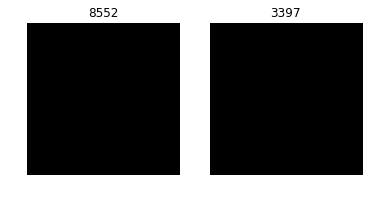

85.57% 85.58% 85.59% 85.65% 85.68% 85.71% 85.76% 85.78% 85.84% 85.87% 85.88% 85.91% 85.95% 85.98% 86.03% 86.05% 86.09% 86.1% 86.13% 86.16% 86.2% 86.21% 86.24% 86.26% 86.29% 86.32% 86.36% 86.39% 86.42% 86.44% 86.51% 86.54% 86.67% 86.74% 86.8% 86.86% 86.87% 86.88% 86.9% 86.91% 86.95% 86.96% 87.01% 87.1% 87.11% 87.12% 87.14% 87.15% 87.17% 87.21% 87.23% 87.25% 87.26% 87.3% 87.31% 87.33% 87.34% 87.42% 87.52% 87.53% 87.55% 87.56% 87.59% 87.62% 87.69% 87.73% 87.74% 87.76% 87.77% 87.84% 87.85% 87.88% 87.89% 87.92% 87.96% 87.97% 87.98% 88.0% 88.04% 88.06% 88.08% 88.1% 88.16% 88.18% 88.22% 88.23% 88.24% 88.26% 88.29% 88.32% 88.33% 88.34% 88.42% 88.43% 88.44% 88.46% 88.48% 88.51% 88.52% 88.55% 88.61% 88.65% 88.68% 88.69% 88.71% 88.74% 88.77% 88.83% 88.85% 88.86% 88.88% 88.9% 88.91% 88.95% 88.98% 89.0% 89.12% 89.16% 89.17% 89.2% 89.23% 89.28% 89.29% 89.37% 89.4% 89.42% 89.43% 89.46% 89.49% 89.57% 89.6% 89.64% 89.68% 89.7% 89.77% 89.78% 89.83% 89.85% 89.87% 89.88% 89.91% 89.96% 89.98% 89.99% 90.03%

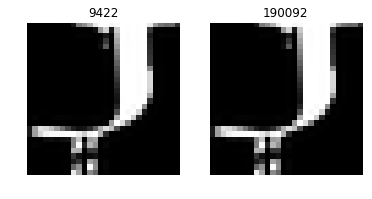

94.41% 94.63% 94.76% 94.79% 94.84% 94.86% 94.94% 94.95% 95.12% 95.18% 95.25% 95.28% 95.34% 95.39% 95.44% 95.61% 95.8% 95.97% 96.17% 96.36% 96.44% 96.46% 96.66% 96.75% 96.76% 96.78% 96.79% 96.81% 96.83% 96.84% 96.95% 96.97% 97.24% 97.27% 97.37% 97.44% 97.63% 97.71% 97.78% 97.86% 97.87% 97.95% 98.03% 98.1% 98.19% 98.34% 98.43% 98.54% 98.59% 98.76% 98.8% 98.89% 98.96% 99.07% 99.14% 99.16% 99.21% 99.25% 99.4% 99.49% 99.52% 99.57% 99.6% 99.61% 99.64% 99.74% 99.95% 99.96% done: 1468


In [304]:
num = 0
for (idx1, idx2) in compare_signatures(a_signatures, c_signatures):
    num += 1
    if num % 200 == 0:
        plt.subplot(121)
        plt.title(str(idx1))
        plt.imshow(a[idx1])
        plt.axis('off')
    
        plt.subplot(122)
        plt.title(str(idx2))
        plt.imshow(c[idx2])
        plt.axis('off')

        plt.show()
    else:
        print('{0}% '.format(idx1 * 100.0 / a_signatures.shape[0]), end='')
print('done: {0}'.format(num))

num = 0
for (idx1, idx2) in compare_signatures(b_signatures, c_signatures):
    num += 1
    if num % 200 == 0:
        plt.subplot(121)
        plt.title(str(idx1))
        plt.imshow(b[idx1])
        plt.axis('off')
    
        plt.subplot(122)
        plt.title(str(idx2))
        plt.imshow(c[idx2])
        plt.axis('off')

        plt.show()
    else:
        print('{0}% '.format(idx1 * 100.0 / b_signatures.shape[0]), end='')
print('done: {0}'.format(num))

---
Problem 6
---------

Let's get an idea of what an off-the-shelf（现成的） classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [21]:
import sklearn.linear_model
for slice in [50, 100, 1000, 5000, train_dataset.shape[0]]:
    classfier = LogisticRegression()
    x = train_dataset[0:slice].reshape(slice, 28*28)
    l = train_labels[0:slice]
    classfier.fit(x, l)
    score = classfier.score(x, l)
    predict_labels = classfier.predict(test_dataset.reshape(test_dataset.shape[0], 28*28))
    correction = np.sum(predict_labels == test_labels)
    print('train set size: {0}, score on train data: {1}, accuracy on test data: {2}'.format(slice, score, correction / test_dataset.shape[0]))

train set size: 50, score on train data: 1.0, accuracy on test data: 0.509
train set size: 100, score on train data: 1.0, accuracy on test data: 0.6966
train set size: 1000, score on train data: 0.997, accuracy on test data: 0.8333


KeyboardInterrupt: 